$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\var}{var}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \DeclareMathOperator{\GP}{\mathcal{GP}}
    \DeclareMathOperator{\l}{\mathscr{l}}
    \newcommand{\Tn}{\mathrm{T}_{n}}
    \newcommand{\Tx}{\mathrm{T}_{x}}
$$

Implement SmoothHMC using the julia `DynamicHMC.jl` package.

In [584]:
using Printf
using TimeSeries
using DataFrames
using GaussianProcesses
using GaussianProcesses: Mean, Kernel, evaluate, metric, IsotropicData
using GaussianProcesses: Stationary, KernelData, predict
import GaussianProcesses: optimize!, get_optim_target, cov, grad_slice!
import GaussianProcesses: num_params, set_params!, get_params, update_mll!, update_mll_and_dmll!
import GaussianProcesses: get_param_names, cov!
import Proj4
using Optim
using Distances
using DataFrames: by, head
using Dates: tonext, Hour, Day
using Distributions
using LinearAlgebra
import Calculus
using Random
using MCMCChain
import MCMCDiagnostics
;

┌ Info: Precompiling MCMCDiagnostics [6e857e4b-079a-58c4-aeab-bc2670384359]
└ @ Base loading.jl:1186


In [2]:
import BenchmarkTools
using BenchmarkTools: @btime

In [41]:
using DynamicHMC
import LogDensityProblems
import PDMats
import LogDensityProblems
import TransformVariables
import ForwardDiff
import ReverseDiff
import Flux
using Nabla
;

┌ Info: Precompiling Nabla [49c96f43-aa6d-5a04-a506-44c7070ebe78]
└ @ Base loading.jl:1186


In [4]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=120.0)
plt.rc("figure", figsize=(12,8))
plt.rc("savefig", dpi=120.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Data import and preprocessing

In [5]:
using TempModel
include("iowa.jl")
data_dir = "../data"
iowa = prepare_iowa_data(data_dir);

┌ Info: Recompiling stale cache file /Users/imolk/Library/Julia/alternative_depots/climate/compiled/v1.1/TempModel/5V5SX.ji for TempModel [429a4ede-8e99-57b3-891e-c3971593d88c]
└ @ Base loading.jl:1184
┌ Warning: dropmissing! will change eltype of cols to disallow missing by default. Use dropmissing!(df, cols, disallowmissing=false) to retain missing.
│   caller = dropmissing!(::DataFrame) at abstractdataframe.jl:733
└ @ DataFrames /Users/imolk/Library/Julia/alternative_depots/climate/packages/DataFrames/IKMvt/src/abstractdataframe/abstractdataframe.jl:733


# Visualizing Test Data: Tn and Tx

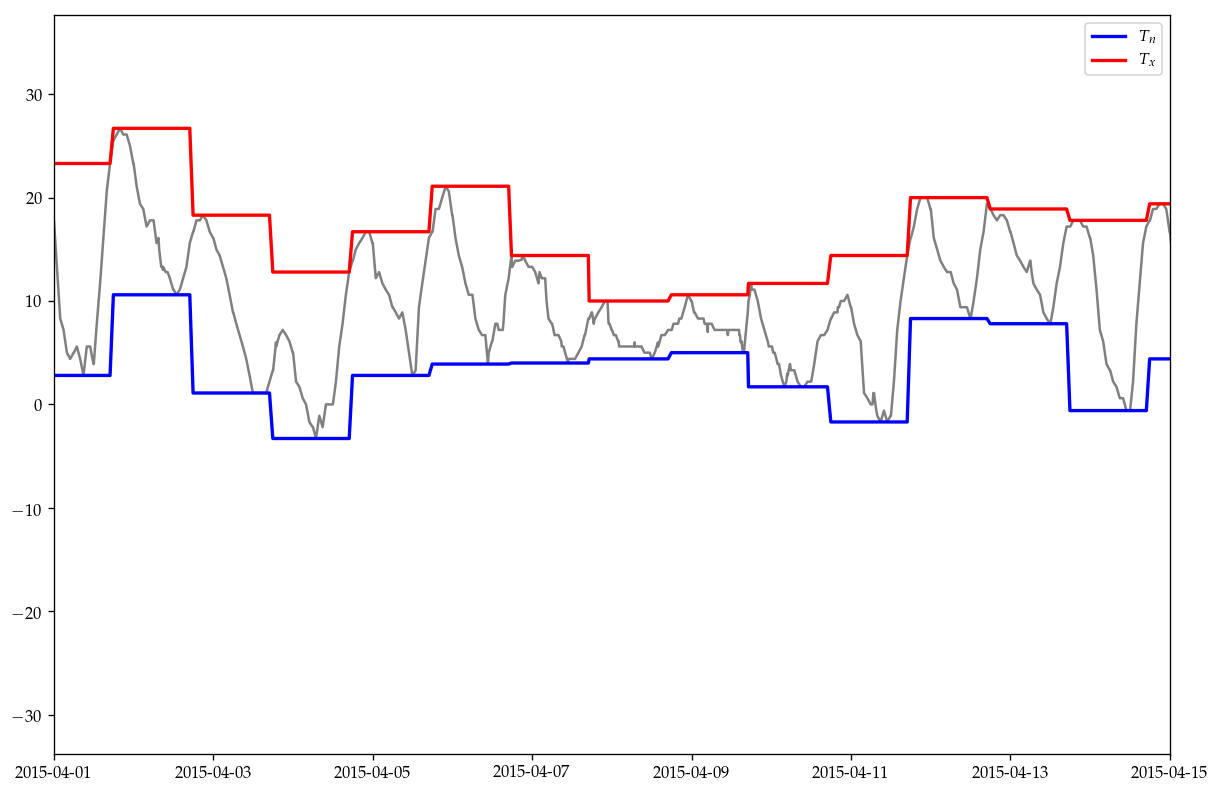

In [6]:
let
    test = iowa[:hourly_test]
    plt.plot(test[:ts], test[:temp], color="grey")
    plt.plot(test[:ts], test[:Tn], color="blue", linewidth=2, label=L"$T_n$")
    plt.plot(test[:ts], test[:Tx], color="red", linewidth=2, label=L"$T_x$")
    plt.xlim(DateTime(2015,4,1),DateTime(2015,4,15)) # random interval
    plt.legend()
end
;

# Kernel Specification

In [7]:
k_spatiotemporal, logNoise = TempModel.fitted_sptemp_SExSE()

(Type: SumKernel{ProdKernel{Masked{SEIso{Float64},1},Masked{FixedKernel{SEIso{Float64},1},2}},FixedKernel{Masked{SEIso{Float64},2},0}}
  Type: ProdKernel{Masked{SEIso{Float64},1},Masked{FixedKernel{SEIso{Float64},1},2}}
    Type: Masked{SEIso{Float64},1}, Params: [0.996834, 1.3172]    Type: Masked{FixedKernel{SEIso{Float64},1},2}, Params: [12.0805]  Type: FixedKernel{Masked{SEIso{Float64},2},0}, Params: Float64[], -0.822261)

# Fitting GP on training data

In [621]:
dt_start, dt_end = DateTime(2015,5,25,18,0,0), DateTime(2015,6,6,16,0,0)
train_subset = TempModel.subset(iowa[:hourly_train], dt_start, dt_end)
test_subset  = TempModel.subset(iowa[:hourly_test],  dt_start, dt_end)

avgtemp=by(train_subset, :station, df->DataFrame(avgtemp=mean(df[:temp])))
train_subset = join(train_subset, avgtemp, on=:station)

train_X_PRJ = iowa[:isdSubset][:X_PRJ][train_subset[:station]]
train_Y_PRJ = iowa[:isdSubset][:Y_PRJ][train_subset[:station]]
train_X = [train_subset[:ts_hours] train_X_PRJ train_Y_PRJ]
train_Y = train_subset[:temp] .- train_subset[:avgtemp]

test_X_PRJ = iowa[:isdSubset][:X_PRJ][test_subset[:station]]
test_Y_PRJ = iowa[:isdSubset][:Y_PRJ][test_subset[:station]]
test_X = [test_subset[:ts_hours] test_X_PRJ test_Y_PRJ]
;

In [622]:
train_GP = GP(train_X', train_Y, MeanZero(), k_spatiotemporal, logNoise);

In [623]:
prior_GP = GP(zeros(3,0), zeros(0), MeanZero(), k_spatiotemporal, logNoise);

## Predicting at the test location

In [625]:
test_prediction=predict_f(train_GP, test_X'; full_cov=true)
prior_prediction=predict_f(prior_GP, test_X'; full_cov=true)
TempModel.add_diag!(test_prediction[2], exp(2*logNoise))
TempModel.add_diag!(prior_prediction[2], exp(2*logNoise))
;

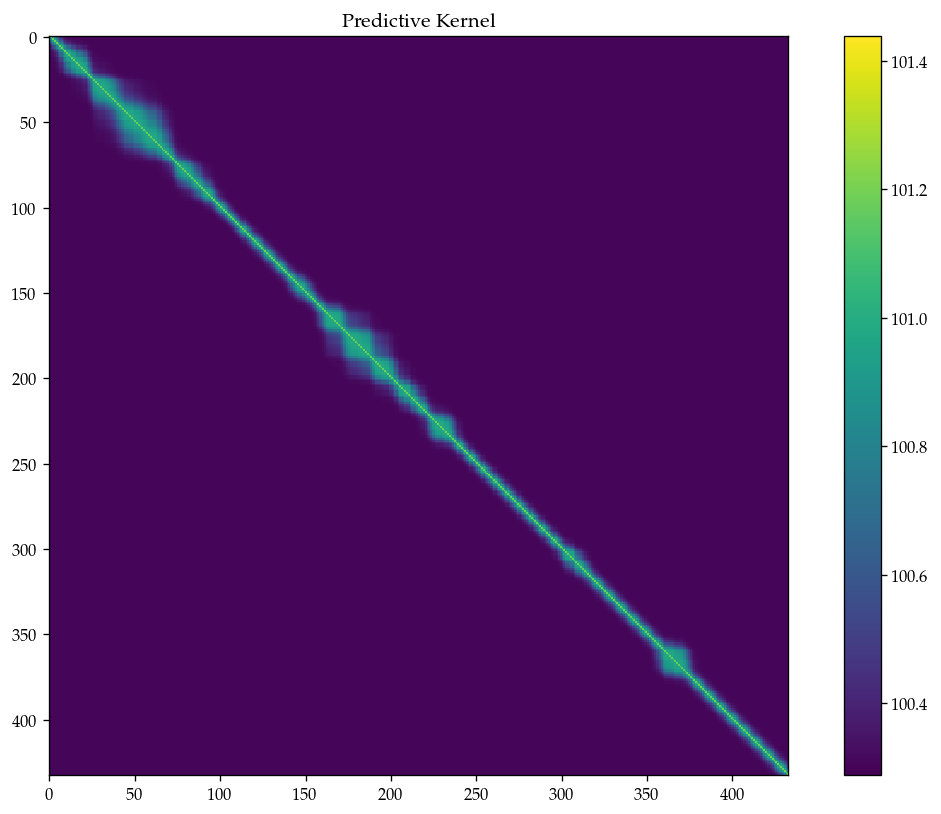

In [626]:
begin
    plt.imshow(Matrix(test_prediction[2]))
    plt.title("Predictive Kernel")
    plt.colorbar()
end
;

## Predictive draws

Let's show some draws from the posterior fitted using the hourly data at nearby stations, but *not* the $T_n$ and $T_x$ records.

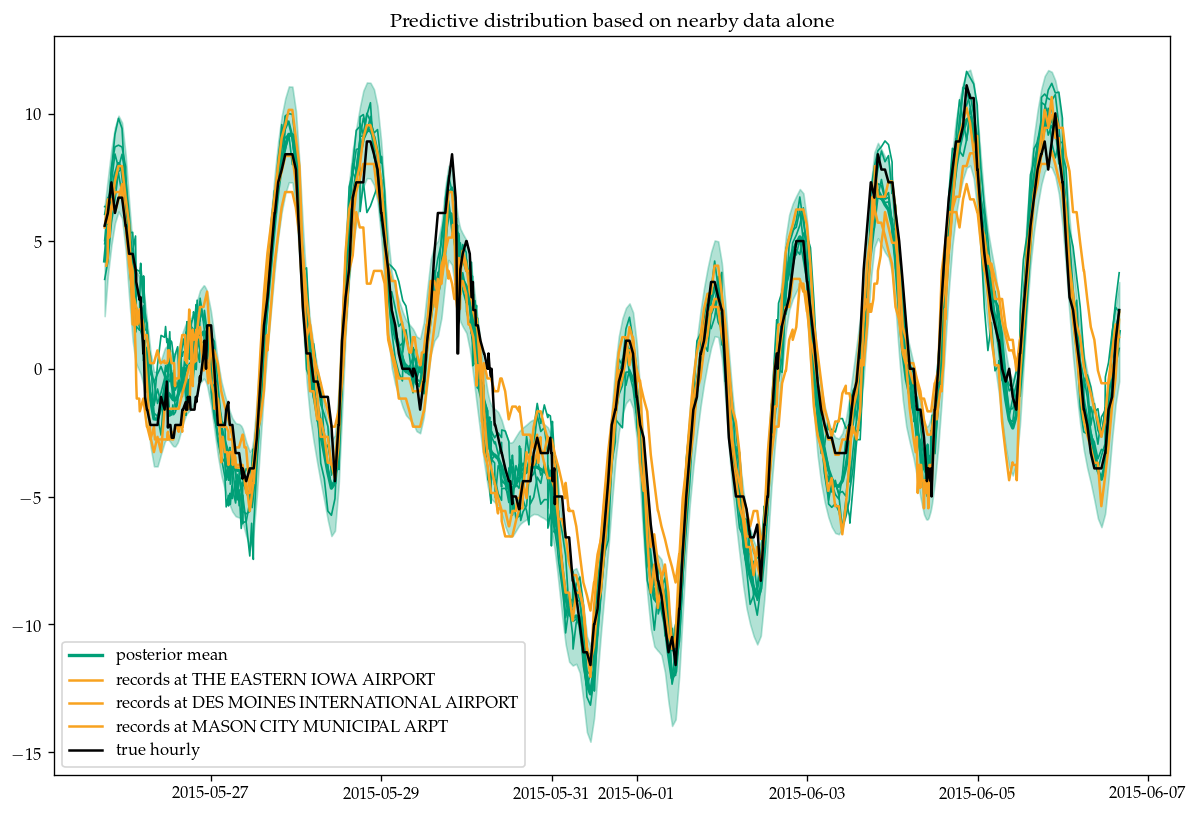

In [627]:
begin
    ts=test_subset[:ts]
    μ = test_prediction[1]
    Σ = test_prediction[2]
    nobsv = length(μ)
    
    centering = Matrix(1.0I, nobsv, nobsv) .- (1.0/nobsv)
    Σ_centered = centering * Matrix(Σ) * centering
    distr = MultivariateNormal(μ, Σ)
    plt.plot(ts, μ, color="#009F77", linewidth=2, label="posterior mean")
    for _ in 1:5
        temp_sim = rand(distr)
        plt.plot(ts, temp_sim.-mean(temp_sim), color="#009F77", linewidth=1)
    end
    y_err = sqrt.(diag(Σ_centered))
    plt.fill_between(ts, μ-2*y_err,μ+2*y_err, color="#009F77", alpha=0.3)
    for station in unique(train_subset[:station])
        sdata = train_subset[train_subset[:station].==station,:]
        ts=sdata[:ts]
        plt.plot(ts, sdata[:temp].-mean(sdata[:temp]), color="#F8A21F", 
            label=string("records at", " ", iowa[:isdSubset][station,:NAME]))
    end
    ts = test_subset[:ts]
    temp_true = test_subset[:temp]
    plt.plot(ts, temp_true.-mean(temp_true), 
        color="black", "-", label="true hourly")
    plt.legend(loc="best")
    plt.title("Predictive distribution based on nearby data alone")
end
;

It's interesting to note that the posterior mean is quite close to the truth, despite the very wide credible envelope. To me this suggests that the information available from nearby stations is underweighted. We should be making more confident predictions.

## preparing Stan data

In [628]:
test_TxTn = by(test_subset, :ts_day, df -> DataFrame(
    Tn=first(df[:Tn]), 
    Tx=first(df[:Tx]), 
    times_p_day=nrow(df),
))

ts_day = test_subset[:ts_day]
day_impute = Int.( (ts_day .- minimum(ts_day)) ./ Day(1) ) .+ 1
L = convert(PDMats.PDMat, test_prediction[2]).chol.L
;

# SmoothHMC module

In [629]:
module SmoothHMC
    using LinearAlgebra
    using PDMats
    import LogDensityProblems
    import LogDensityProblems: dimension, logdensity
    using LogDensityProblems: Value, ValueGradient
    struct PredictTemperatures <: LogDensityProblems.AbstractLogDensityProblem
        impt_times_p_day::Vector{Int}
        Tn::Vector{Float64}
        Tx::Vector{Float64}
        μ::Vector{Float64}
        chol::LowerTriangular{Float64,Array{Float64,2}}
        cholmat::Matrix{Float64}
        Nimpt::Int
        day_impute::Vector{Int}
        k_smoothmax::Float64
        epsilon::Float64
        N_TnTx::Int
    end
    smoothmax(x, k, maxkx) = (maxkx + log(sum(xi ->exp(k*xi - maxkx), x)))/k
    smoothmin(x, k, minkx) = (minkx - log(sum(xi ->exp(-k*xi + minkx), x)))/k
    
    dsmoothmax_dx(x, k, maxkx) = exp.( k.*x .- maxkx) ./ sum(xi ->exp( k*xi - maxkx), x)
    dsmoothmin_dx(x, k, maxkx) = exp.(-k.*x .+ maxkx) ./ sum(xi ->exp(-k*xi + maxkx), x)
    function loglik(pt::PredictTemperatures, θ::Vector)
        w_uncorr = θ
        temp_impt = pt.μ + pt.chol*w_uncorr
        
        dayend = cumsum(pt.impt_times_p_day)
        daystart = [1; dayend[1:end-1].-1]
        k = pt.k_smoothmax
        Tsmoothmin = [smoothmin(@view(temp_impt[daystart[i]:dayend[i]]), k, k*pt.Tn[i])
                      for i in 1:pt.N_TnTx]
        Tsmoothmax = [smoothmax(@view(temp_impt[daystart[i]:dayend[i]]), k, k*pt.Tx[i])
                              for i in 1:pt.N_TnTx]
        Tn_loglik = -sum(i -> (Tsmoothmin[i] - pt.Tn[i])^2, 1:pt.N_TnTx)  / (2*pt.epsilon^2)
        Tx_loglik = -sum(i -> (Tsmoothmax[i] - pt.Tx[i])^2 , 1:pt.N_TnTx) / (2*pt.epsilon^2)
        return Tn_loglik + Tx_loglik # + constant
    end    
    function loglik(pt::PredictTemperatures, θ)
        w_uncorr = θ
        temp_impt = pt.μ + pt.chol*w_uncorr
        
        dayend = cumsum(pt.impt_times_p_day)
        daystart = [1; dayend[1:end-1].-1]
        k = pt.k_smoothmax
        Tsmoothmin = [smoothmin(temp_impt[daystart[i]:dayend[i]], k, k*pt.Tn[i])
                      for i in 1:pt.N_TnTx]
        Tsmoothmax = [smoothmax(temp_impt[daystart[i]:dayend[i]], k, k*pt.Tx[i])
                              for i in 1:pt.N_TnTx]
        Tn_loglik = -sum(i -> (Tsmoothmin[i] - pt.Tn[i])^2, 1:pt.N_TnTx)  / (2*pt.epsilon^2)
        Tx_loglik = -sum(i -> (Tsmoothmax[i] - pt.Tx[i])^2 , 1:pt.N_TnTx) / (2*pt.epsilon^2)
        return Tn_loglik + Tx_loglik # + constant
    end
    function loglik_mat(pt::PredictTemperatures, θ)
        w_uncorr = θ
        temp_impt = pt.μ + pt.cholmat*w_uncorr
        
        dayend = cumsum(pt.impt_times_p_day)
        daystart = [1; dayend[1:end-1].-1]
        k = pt.k_smoothmax
        Tsmoothmin = [smoothmin(temp_impt[daystart[i]:dayend[i]], k, k*pt.Tn[i])
                      for i in 1:pt.N_TnTx]
        Tsmoothmax = [smoothmax(temp_impt[daystart[i]:dayend[i]], k, k*pt.Tx[i])
                              for i in 1:pt.N_TnTx]
        Tn_loglik = -sum(i -> (Tsmoothmin[i] - pt.Tn[i])^2, 1:pt.N_TnTx)  / (2*pt.epsilon^2)
        Tx_loglik = -sum(i -> (Tsmoothmax[i] - pt.Tx[i])^2 , 1:pt.N_TnTx) / (2*pt.epsilon^2)
        return Tn_loglik + Tx_loglik # + constant
    end
    function loglik_mat(pt::PredictTemperatures, θ::Vector)
        w_uncorr = θ
        temp_impt = pt.μ + pt.cholmat*w_uncorr
        
        dayend = cumsum(pt.impt_times_p_day)
        @assert dayend[end] == length(θ)
        daystart = [1; dayend[1:end-1].+1]
        k = pt.k_smoothmax
        Tsmoothmin = [smoothmin(@view(temp_impt[daystart[i]:dayend[i]]), k, k*pt.Tn[i])
                      for i in 1:pt.N_TnTx]
        Tsmoothmax = [smoothmax(@view(temp_impt[daystart[i]:dayend[i]]), k, k*pt.Tx[i])
                              for i in 1:pt.N_TnTx]
        Tn_loglik = -sum(i -> (Tsmoothmin[i] - pt.Tn[i])^2, 1:pt.N_TnTx)  / (2*pt.epsilon^2)
        Tx_loglik = -sum(i -> (Tsmoothmax[i] - pt.Tx[i])^2 , 1:pt.N_TnTx) / (2*pt.epsilon^2)
        return Tn_loglik + Tx_loglik # + constant
    end
    function logprior(θ)
        return -sum(x -> x^2, θ)/2
    end
    function dlogpriordθ(θ)
        return -θ
    end
    logtarget(pt::PredictTemperatures, θ) = logprior(θ) + loglik(pt, θ)
    logtarget_mat(pt::PredictTemperatures, θ) = logprior(θ) + loglik_mat(pt, θ)

    function dloglikdθ(pt::PredictTemperatures, θ)
        temp_impt = pt.μ + pt.chol*θ
        
        dayend = cumsum(pt.impt_times_p_day)
        daystart = [1; dayend[1:end-1].+1]
        k = pt.k_smoothmax
        
        loglik = 0.0
        ntemp = length(temp_impt)
        dloglik_dtemp = Vector{Float64}(undef, ntemp)
        @inbounds for day in 1:pt.N_TnTx
            times = daystart[day]:dayend[day]
            temp_day = temp_impt[times]
            Tsmoothmin = smoothmin(temp_day, k, k*pt.Tn[day])
            Tsmoothmax = smoothmax(temp_day, k, k*pt.Tx[day])
            loglik +=  -(Tsmoothmin - pt.Tn[day])^2
            loglik +=  -(Tsmoothmax - pt.Tx[day])^2
            
            dloglik_dTsmoothmin = -(Tsmoothmin .- pt.Tn[day])
            dloglik_dTsmoothmax = -(Tsmoothmax .- pt.Tx[day])
            dloglik_dtemp[times]   = dloglik_dTsmoothmin .* dsmoothmin_dx(temp_day, k, k*pt.Tn[day])
            dloglik_dtemp[times] .+= dloglik_dTsmoothmax .* dsmoothmax_dx(temp_day, k, k*pt.Tx[day])
        end
        loglik /= (2*pt.epsilon^2)
        dloglik_dθ = dloglik_dtemp
        lmul!(pt.chol', dloglik_dθ)
        dloglik_dθ ./= (pt.epsilon^2)
        return loglik, vec(dloglik_dθ)
    end
    
    function dlogtargetdθ(pt::PredictTemperatures, θ)
        loglik, dloglik = dloglikdθ(pt, θ)
        dprior = dlogpriordθ(θ)
        prior = logprior(θ)
        return loglik+prior, dloglik.+dprior
    end
    # LogDensityProblem interface
    dimension(pt::PredictTemperatures) = pt.Nimpt
    function logdensity(::Type{LogDensityProblems.ValueGradient}, pt::PredictTemperatures, θ::AbstractVector)
        logtarget, dlogtarget = dlogtargetdθ(pt, θ)
        if !isfinite(logtarget)
            logtarget = -Inf
        else
            if !all(isfinite, dlogtarget)
                @show θ
            end
            @assert all(isfinite, dlogtarget)
        end
        return ValueGradient(logtarget, dlogtarget)
    end
    function logdensity(::Type{LogDensityProblems.Value}, pt::PredictTemperatures, θ::AbstractVector)
        val = Value(logtarget(pt, θ))
        if !isfinite(val)
            return -Inf
        end
    end
end

pt = SmoothHMC.PredictTemperatures(test_TxTn[:times_p_day], test_TxTn[:Tn], test_TxTn[:Tx],
               test_prediction[1], L, Matrix(L), nrow(test_subset), day_impute, 
                   20.0, # steep smoothmax
                   0.01,# tight epsilon!
                   nrow(test_TxTn))
;

In [631]:
Random.seed!(1)
x = randn(pt.Nimpt)
SmoothHMC.logtarget(pt, x), SmoothHMC.dlogtargetdθ(pt, x)[1]

(-3.1657038908534672e7, -3.1657038908534676e7)

In [20]:
Random.seed!(1)
x = randn(340)
SmoothHMC.smoothmax(x, 2, 1.0)
f = x -> SmoothHMC.smoothmax(x, 2, 2.0)
@assert Calculus.gradient(f, x) ≈ SmoothHMC.dsmoothmax_dx(x, 2, 1.0)
f = x -> SmoothHMC.smoothmin(x, 2, -2.0)
@assert Calculus.gradient(f, x) ≈ SmoothHMC.dsmoothmin_dx(x, 2, -2.0)
f = x -> SmoothHMC.loglik(pt, x)
@assert Calculus.gradient(f, x) ≈SmoothHMC.dloglikdθ(pt, x);

In [633]:
@btime SmoothHMC.dloglikdθ(pt, x);

  96.624 μs (87 allocations: 34.31 KiB)


In [24]:
nimpt = nrow(test_subset)
logposterior_transf = LogDensityProblems.TransformedLogDensity(
    TransformVariables.as(Array, nimpt), 
    θ -> SmoothHMC.logtarget(pt, θ))
;

In [25]:
logposterior_mat_transf = LogDensityProblems.TransformedLogDensity(
    TransformVariables.as(Array, nimpt), 
    θ -> SmoothHMC.logtarget_mat(pt, θ))
;

In [46]:
import Random
Random.seed!(1)
x = randn(nimpt)
SmoothHMC.logtarget(pt, x);
@btime SmoothHMC.logtarget(pt, x);

  41.445 μs (52 allocations: 8.41 KiB)


In [29]:
SmoothHMC.logtarget_mat(pt, x);
@time SmoothHMC.logtarget_mat(pt, x);

  0.000125 seconds (56 allocations: 8.563 KiB)


In [30]:
lp = θ -> SmoothHMC.logtarget(pt, θ)
Calculus.gradient(lp, x);
@time Calculus.gradient(lp, x)[1:10]

  0.045768 seconds (35.12 k allocations: 5.598 MiB)


10-element Array{Float64,1}:
 274297.5939955387   
  15683.013062767666 
   9956.813796966837 
   7890.6921381102775
   7294.017537858385 
   7088.660744899114 
   6826.580830238638 
   3321.315957416346 
   4368.822944927901 
   4656.718370111613 

In [40]:
@btime SmoothHMC.dlogtargetdθ(pt, x)[1:10]

  70.180 μs (74 allocations: 32.80 KiB)


10-element Array{Float64,1}:
 274297.59399985924  
  15683.013064934838 
   9956.813792603425 
   7890.692138889545 
   7294.017535721567 
   7088.660745775225 
   6826.580830920148 
   3321.3159563917393
   4368.822939913133 
   4656.718368665865 

In [32]:
import Calculus
lp_mat = θ -> SmoothHMC.logtarget_mat(pt, θ)
Calculus.gradient(lp_mat, x);
@time Calculus.gradient(lp_mat, x)[1:10]

  0.039947 seconds (34.69 k allocations: 5.575 MiB)


10-element Array{Float64,1}:
 274297.594002748   
  15683.013067573884
   9956.81379216062 
   7890.692140513386
   7294.017537858385
   7088.660744899114
   6826.580831285704
   3321.315957416346
   4368.822944927901
   4656.718365305395

In [33]:
logposterior_grad = LogDensityProblems.ADgradient(:ForwardDiff, logposterior_transf);
@btime LogDensityProblems.logdensity($LogDensityProblems.ValueGradient, $logposterior_grad, $x).gradient[1:10]

  106.396 ms (1717 allocations: 335.58 MiB)


10-element Array{Float64,1}:
 274297.59399744426 
  15683.013064797244
   9956.813792517227
   7890.692138822917
   7294.017535660378
   7088.660745715639
   6826.580830864309
   3321.315956360926
   4368.822939872602
   4656.718368622754

In [34]:
logposterior_reverse = LogDensityProblems.ADgradient(:ReverseDiff, logposterior_transf);
@btime LogDensityProblems.logdensity($LogDensityProblems.ValueGradient, $logposterior_reverse, $x).gradient[1:10]

  84.476 ms (831860 allocations: 28.08 MiB)


10-element Array{Float64,1}:
 274297.59399744426  
  15683.013064797246 
   9956.813792517229 
   7890.692138822923 
   7294.01753566038  
   7088.6607457156315
   6826.580830864314 
   3321.3159563609274
   4368.8229398726035
   4656.718368622753 

In [35]:
logposterior_reverse = LogDensityProblems.ADgradient(:ReverseDiff, logposterior_mat_transf);
@btime LogDensityProblems.logdensity($LogDensityProblems.ValueGradient, $logposterior_reverse, $x).gradient[1:10]

  150.847 ms (1415640 allocations: 45.02 MiB)


10-element Array{Float64,1}:
 274297.5939998591  
  15683.013064934834
   9956.813792603425
   7890.692138889548
   7294.017535721566
   7088.660745775226
   6826.580830920153
   3321.315956391738
   4368.822939913128
   4656.718368665866

In [42]:
∇lp = Nabla.∇(lp)
∇lp(x)
@btime ∇lp(x)[1][1:10]

  912.611 μs (3277 allocations: 130.77 KiB)


10-element Array{Float64,1}:
 274297.5939974443   
  15683.013064797244 
   9956.813792517229 
   7890.692138822919 
   7294.0175356603795
   7088.660745715639 
   6826.580830864311 
   3321.315956360926 
   4368.822939872603 
   4656.718368622753 

In [43]:
∇lp_mat = Nabla.∇(lp_mat)
∇lp_mat(x)
@btime ∇lp_mat(x)[1][1:10]

  862.405 μs (3277 allocations: 130.77 KiB)


10-element Array{Float64,1}:
 274297.5939974443   
  15683.013064797244 
   9956.813792517229 
   7890.692138822917 
   7294.017535660377 
   7088.660745715637 
   6826.58083086431  
   3321.3159563609256
   4368.822939872602 
   4656.718368622754 

In [38]:
# with tape?
logposterior_reverse = LogDensityProblems.ADgradient(:ReverseDiff, logposterior_transf; tape=true);
@btime LogDensityProblems.logdensity($LogDensityProblems.ValueGradient, $logposterior_reverse, $x).gradient[1:10]

  7.929 ms (2 allocations: 192 bytes)


10-element Array{Float64,1}:
 274297.59399744426  
  15683.013064797246 
   9956.813792517229 
   7890.692138822923 
   7294.01753566038  
   7088.6607457156315
   6826.580830864314 
   3321.3159563609274
   4368.8229398726035
   4656.718368622753 

In [39]:
logposterior_flux = LogDensityProblems.ADgradient(:Flux, logposterior_transf);
@btime LogDensityProblems.logdensity($LogDensityProblems.ValueGradient, $logposterior_flux, $x).gradient;

  824.988 ms (2136973 allocations: 71.90 MiB)


**Conclusions:** 
**ForwardDiff** is taking about 2000 longer than just evaluating the target, and 3 times longer than brute-force numerical differentiation. **ReverseDiff** (with tape) is much faster, but still takes 200x longer than target evaluation, 10x faster than `ForwardDiff`. Flux is ludicrously slow.

**Nabla** is the fastest autodiff package, and takes 912.611 μs/41.445  μs = 12 times longer than target evaluation. Pretty good!

My traditional implementation of the gradient takes only twice longer than target evaluation. So much for autodiff today.

In [278]:
DynamicHMC.checksquare(κ.Minv) ==
DynamicHMC.checksquare(κ.W)

true

In [635]:
ℓ = pt
rng = DynamicHMC.Random.GLOBAL_RNG
@time samplr = DynamicHMC.NUTS_init(rng, ℓ, ϵ=4e-4, max_depth=10)

κ = DynamicHMC.GaussianKE(Diagonal([100.0; ones(pt.Nimpt-1)]))
H = DynamicHMC.Hamiltonian(ℓ, κ)
samplr = DynamicHMC.NUTS(rng, H, samplr.q, samplr.ϵ, samplr.max_depth, samplr.report)
;

  0.099233 seconds (130.50 k allocations: 6.870 MiB)


In [636]:
@time chain, samplr_tuned = DynamicHMC.NUTS_init_tune_mcmc(pt, 500; ϵ=5e-4, max_depth=10);

MCMC, adapting ϵ (75 steps)
0.046 s/step ...done
MCMC, adapting ϵ (25 steps)
0.13 s/step ...done
MCMC, adapting ϵ (50 steps)
0.19 s/step ...done
MCMC, adapting ϵ (100 steps)
step 100 (of 100), 0.19 s/step
0.19 s/step ...done
MCMC, adapting ϵ (200 steps)
step 100 (of 200), 0.22 s/step
step 200 (of 200), 0.22 s/step
0.22 s/step ...done
MCMC, adapting ϵ (400 steps)
step 100 (of 400), 0.2 s/step
step 200 (of 400), 0.21 s/step
step 300 (of 400), 0.21 s/step
step 400 (of 400), 0.22 s/step
0.22 s/step ...done
MCMC, adapting ϵ (50 steps)
0.21 s/step ...done
MCMC (500 steps)
step 100 (of 500), 0.26 s/step
step 200 (of 500), 0.28 s/step
step 300 (of 500), 0.27 s/step
step 400 (of 500), 0.26 s/step


306.926545 seconds (145.60 M allocations: 100.072 GiB, 9.95% gc time)


step 500 (of 500), 0.26 s/step
0.26 s/step ...done


In [637]:
NUTS_statistics(chain)

Hamiltonian Monte Carlo sample of length 500
  acceptance rate mean: 0.93, min/25%/median/75%/max: 0.43 0.9 0.97 0.99 1.0
  termination: MaxDepth => 100%
  depth: 10 => 100%


In [638]:
samplr_tuned.ϵ

0.0025171957280004558

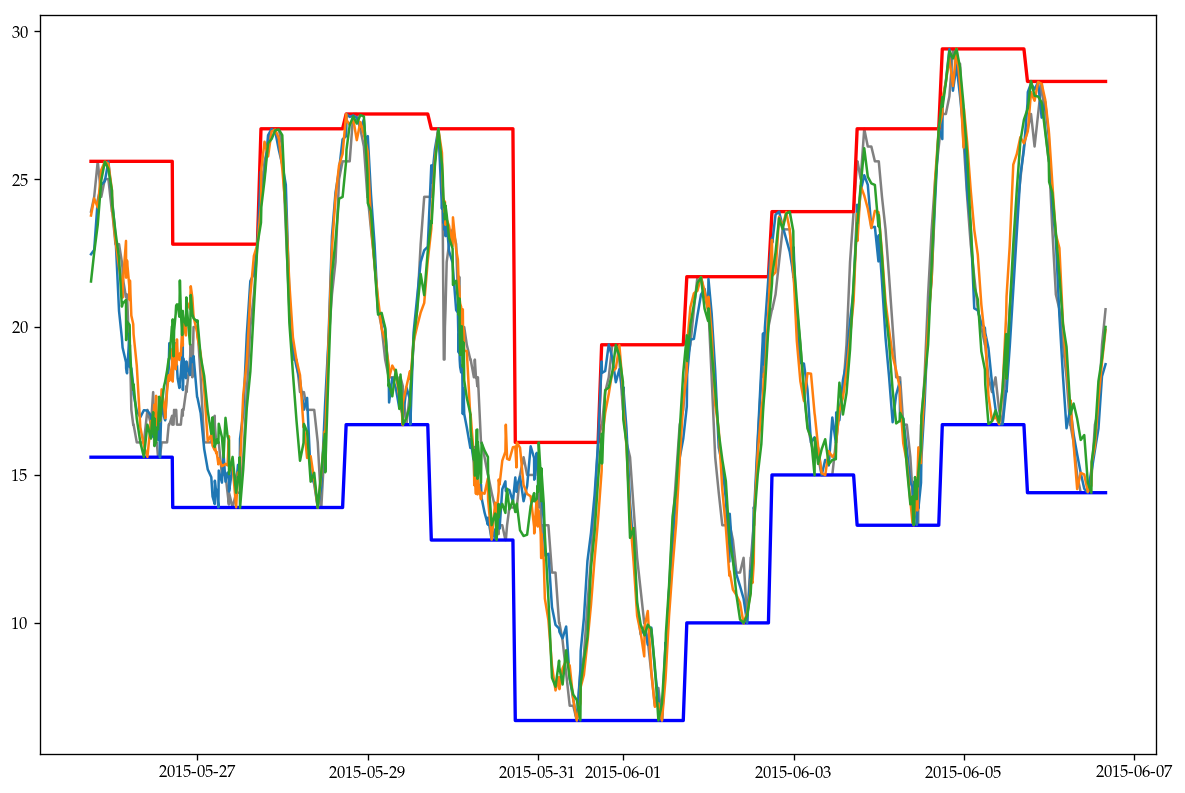

In [640]:
let
    test = test_subset
    plt.plot(test[:ts], test[:temp], color="grey")
    plt.plot(test[:ts], test[:Tn], color="blue", linewidth=2, label=L"$T_n$")
    plt.plot(test[:ts], test[:Tx], color="red", linewidth=2, label=L"$T_x$")
end
;

for i in (100,300,500)
    c=chain[i]
    imputed = pt.μ + pt.chol*c.q
    plt.plot(ts, imputed)
end
;

# Optimization

In [641]:
f = θ -> -SmoothHMC.logtarget(pt, θ)
df = function(grad, θ)
    grad[:] = -SmoothHMC.dlogtargetdθ(pt, θ)[2]
end
fdf = function(grad, θ)
    targ, dtarg = SmoothHMC.dlogtargetdθ(pt, θ)
    grad[:] = -dtarg
    return -targ
end
od = OnceDifferentiable(f, df, fdf, randn(pt.Nimpt))
opt_out = Optim.optimize(od, randn(pt.Nimpt); f_tol=1e-16, x_tol=1e-16)

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [-1.238838981725883,0.11978495480971767, ...]
 * Minimizer: [1.8212982311305288,-0.06325769459699962, ...]
 * Minimum: 1.285400e+01
 * Iterations: 1000
 * Convergence: false
   * |x - x'| ≤ 1.0e-16: false 
     |x - x'| = 3.64e-05 
   * |f(x) - f(x')| ≤ 1.0e-16 |f(x)|: false
     |f(x) - f(x')| = 8.76e-09 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 2.83e-01 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: true
 * Objective Calls: 2883
 * Gradient Calls: 2883

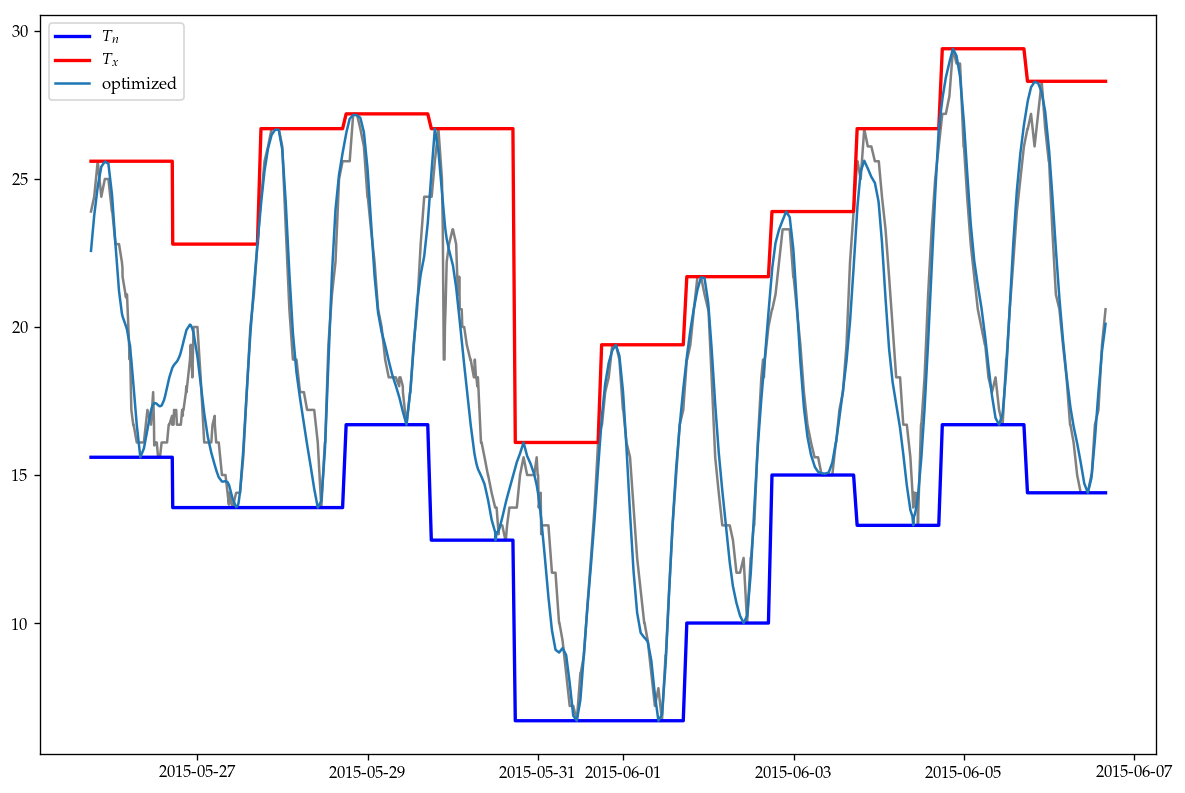

In [642]:
let
    test = test_subset
    plt.plot(test[:ts], test[:temp], color="grey")
    plt.plot(test[:ts], test[:Tn], color="blue", linewidth=2, label=L"$T_n$")
    plt.plot(test[:ts], test[:Tx], color="red", linewidth=2, label=L"$T_x$")
end
;

imputed = pt.μ + pt.chol*Optim.minimizer(opt_out)
plt.plot(ts, imputed, label="optimized")
plt.legend()
;

# Empirical HMC

In [511]:
module eHMC
    using DynamicHMC: leapfrog, PhasePoint, Hamiltonian, phasepoint_in, neg_energy
    using LinearAlgebra
    using PDMats: AbstractPDMat
    using Distributions: MvNormal, DiscreteUnivariateDistribution, Categorical
    using Random
    using Random: AbstractRNG, GLOBAL_RNG
    function longestbatch(H::Hamiltonian, θ, v, ϵ, L::Int; verbose::Bool=false)
        ℓ=0
        θstep, vstep = copy(θ), copy(v)
        θstar, vstar = copy(θ), copy(v)
        while dot(θstep-θ, vstep) >= 0
            # stop when we start moving back towards \theta
            ℓ += 1
            if verbose
                @show ℓ
            end
            zstep = phasepoint_in(H, θstep, vstep)
            zstep = leapfrog(H, zstep, ϵ)
            θstep, vstep = zstep.q, zstep.p
            if ℓ==L
                θstar, vstar = θstep, vstep
            end
        end
        return (θstar, vstar, ℓ)
    end
    function longestbatch_distrib(H::Hamiltonian, θ, ϵ, L₀; nsamples::Int, rng::AbstractRNG=GLOBAL_RNG, verbose::Bool=false)
        θprev = θ
        Lrecord = Vector{Int}(undef, nsamples)
        naccept = 0
        nreject = 0
        for k in 1:nsamples
            v = rand(rng, H.κ) # z = rand_phasepoint(rng, H, θ)
            θstar, vstar, Lk = longestbatch(H, θprev, v, ϵ, L₀)
            Lrecord[k] = Lk
            if Lk < L₀
                for _ in 1:(L₀-Lk)
                    zstar = phasepoint_in(H, θstar, vstar)
                    zstar = leapfrog(H, zstar, ϵ)
                    θstar,vstar = zstar.q, zstar.p
                end
            end
            zprop = phasepoint_in(H, θstar, -vstar)
            zrjct = phasepoint_in(H, θprev, v)
            logρ = min(0,
                neg_energy(H, zprop) - neg_energy(H, zrjct))
            if -randexp() < logρ
                # accept
                θk, vk = θstar, -vstar
                naccept += 1
            else
                # reject
                θk, vk = θprev, v
                nreject += 1
            end
            θprev = θk
            if verbose
                print(".")
                print(Lk)
            end
        end
        @show naccept
        @show nreject
        return Lrecord
    end
    function empirical_distribution(xsamples::Vector{Int})
        xmax = maximum(xsamples)
        @assert minimum(xsamples) >= 1
        counts = fill(0, xmax)
        for x in xsamples
            counts[x] += 1
        end
        prob = counts ./ length(xsamples)
        return Categorical(prob)
    end
        
    function empiricalHMC(H::Hamiltonian, θ, ϵ, Ldistrib::DiscreteUnivariateDistribution; nsamples::Int, rng::AbstractRNG=GLOBAL_RNG)
        θprev = θ
        naccept = 0
        nreject = 0
        θrecord = Vector{typeof(θ)}(undef, nsamples)
        for n in 1:nsamples
            v = rand(rng, H.κ) # z = rand_phasepoint(rng, H, θ)
            L = rand(Ldistrib)
            θstar, vstar = copy(θprev), copy(v)
            for _ in 1:L
                zstar = phasepoint_in(H, θstar, vstar)
                zstar = leapfrog(H, zstar, ϵ)
                θstar,vstar = zstar.q, zstar.p
            end

            zprop = phasepoint_in(H, θstar, -vstar)
            zrjct = phasepoint_in(H, θprev, v)
            logρ = min(0,
                neg_energy(H, zprop) - neg_energy(H, zrjct))
            if -randexp() < logρ
                # accept
                θn, vn = θstar, -vstar
                naccept += 1
            else
                # reject
                θn, vn = θprev, v
                nreject += 1
            end
            θrecord[n] = θn
            θprev = θn
        end
        @show naccept
        @show nreject
        return θrecord
    end
end

Main.eHMC

In [512]:
κ = DynamicHMC.GaussianKE(Diagonal([100.0; ones(pt.Nimpt-1)]))
H = DynamicHMC.Hamiltonian(pt, κ)
;

In [513]:
qopt = Optim.minimizer(opt_out)
eHMC.longestbatch(H, qopt, rand(H.κ), 1e-3, 10; verbose=false)[3]

2

In [525]:
eHMC.longestbatch(H, randn(pt.Nimpt), rand(H.κ), 1e-4, 10; verbose=false)[3]

8

In [548]:
qopt = Optim.minimizer(opt_out)
ϵ = 4.4e-4
@time Lrecord = eHMC.longestbatch_distrib(H, qopt, ϵ, 3000; nsamples=10, verbose=true)
Ldistrib = eHMC.empirical_distribution(Lrecord)

.3594.3651.3574.7681.7073.7079.7151.6821.6916.7330naccept = 5
nreject = 5
 11.532979 seconds (9.80 M allocations: 5.271 GiB, 12.50% gc time)


Categorical{Float64}(
K: 7681
p: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1]
)


In [643]:
qopt = Optim.minimizer(opt_out)
@time Lrecord = eHMC.longestbatch_distrib(samplr_tuned.H, randn(pt.Nimpt), samplr_tuned.ϵ, 500; nsamples=100, verbose=true)
Ldistrib = eHMC.empirical_distribution(Lrecord)
;

.3.3.3.3.3.3.3.3.3.3.3.3.3.3.752.739.796.623.706.866.793.730.753.616.816.669.747.800.617.596.811.791.766.717.772.684.574.669.798.798.811.737.756.745.756.745.751.611.806.743.745.762.802.819.848.577.689.796.815.783.725.827.758.586.806.744.624.701.803.748.786.758.857.684.762.827.763.855.608.685.823.802.619.737.754.824.816.687.612.808.762.754.744.645.699.913.570.748.691.690naccept = 1
nreject = 99
 22.026769 seconds (13.82 M allocations: 7.761 GiB, 10.23% gc time)


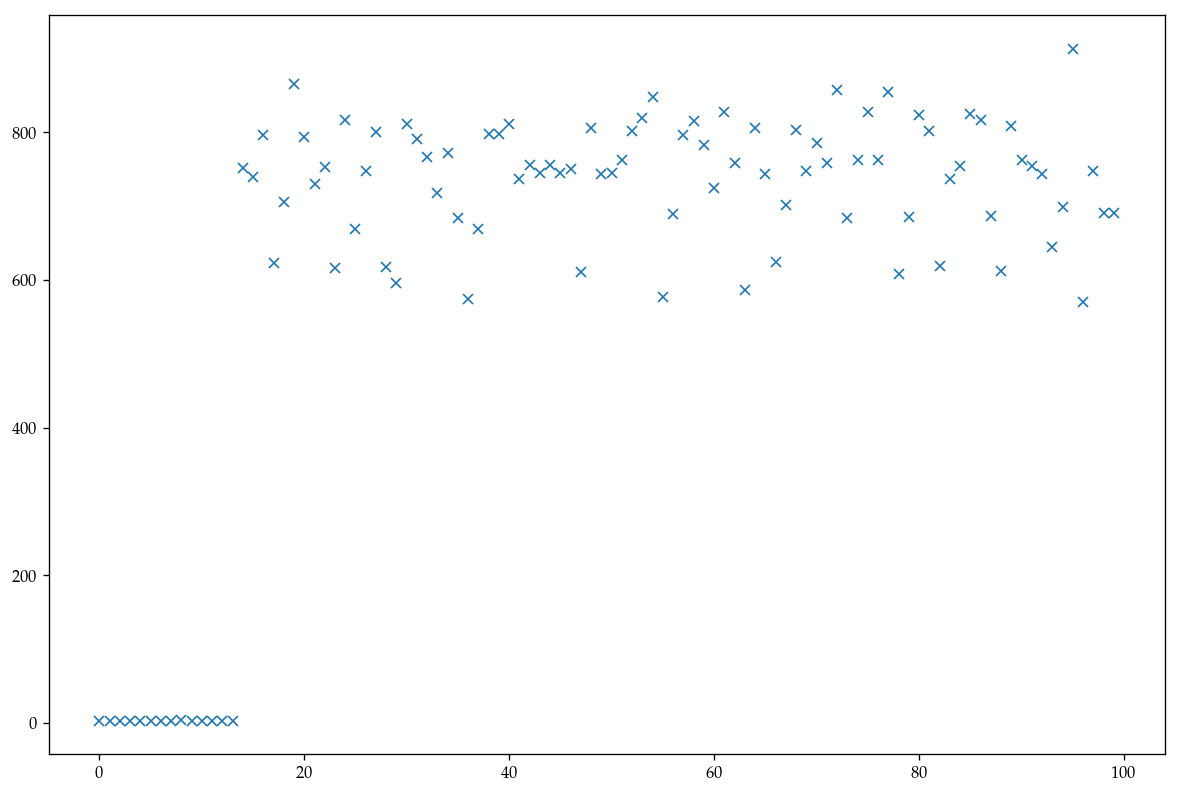

In [644]:
plt.plot(Lrecord .+ 0.5.*(rand(length(Lrecord)) .- 0.5), "x")
;

In [645]:
@time chain_eHMC = eHMC.empiricalHMC(samplr_tuned.H, samplr_tuned.q, 
        samplr_tuned.ϵ, Ldistrib; 
        nsamples=500);
;

naccept = 469
nreject = 31
 99.257655 seconds (59.81 M allocations: 33.410 GiB, 9.92% gc time)


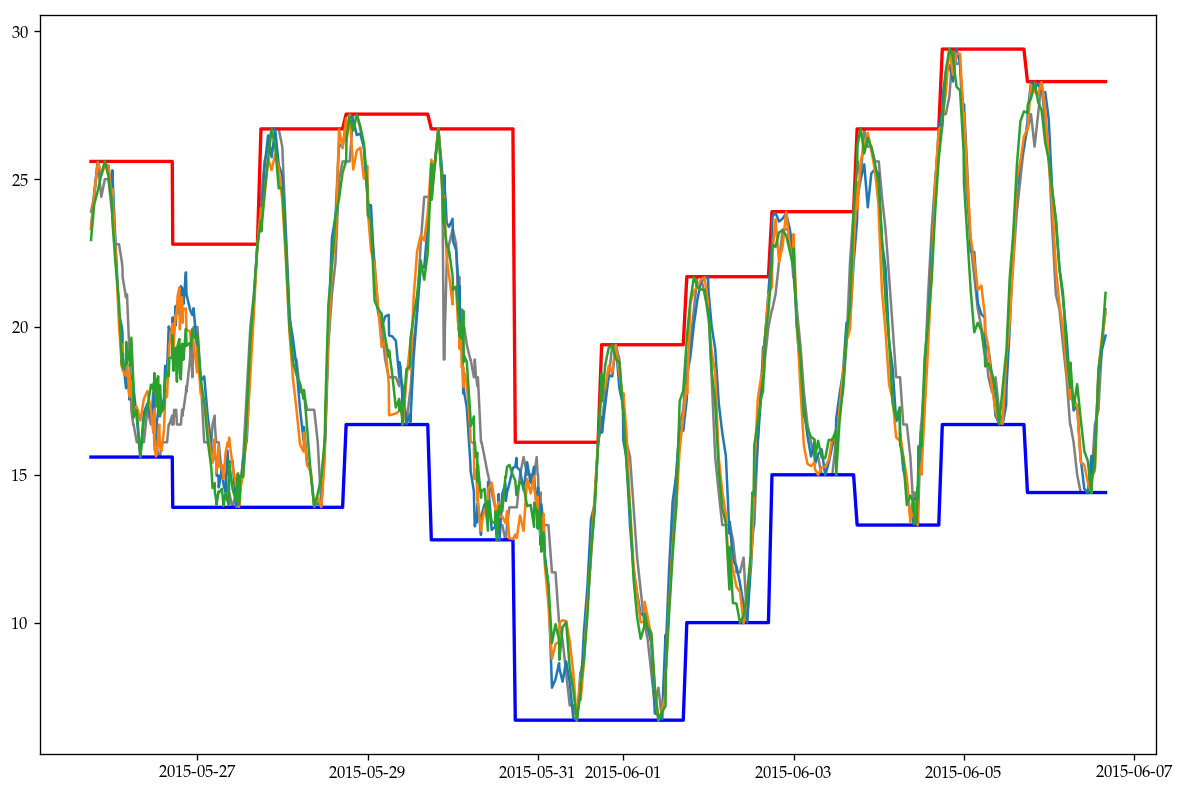

In [646]:
let
    test = test_subset
    plt.plot(test[:ts], test[:temp], color="grey")
    plt.plot(test[:ts], test[:Tn], color="blue", linewidth=2, label=L"$T_n$")
    plt.plot(test[:ts], test[:Tx], color="red", linewidth=2, label=L"$T_x$")
end
;

for i in (50,100,150)
    q=chain_eHMC[i]
    imputed = pt.μ + pt.chol*q
    plt.plot(ts, imputed)
end
;

# Effective sample size

In [581]:
mcmcchain_eHMC = MCMCChain.Chains(
    reshape(
        Matrix(hcat(chain_eHMC...)'), 
        (length(chain_eHMC), pt.Nimpt, 1)))

Object of type "Chains{Float64}"

Iterations = 1:200
Thinning interval = 1
Chains = 1
Samples per chain = 200

Union{Missing, Float64}[1.87574 -0.970363 … 1.31418 -0.926708; 1.66704 -0.00545464 … -0.616953 -1.62955; … ; 1.78828 -1.45518 … -0.179088 0.163343; 1.69993 -0.73537 … -0.870739 0.0468395]

In [647]:
meanESS_eHMC = mean(
    MCMCDiagnostics.effective_sample_size(hcat(chain_eHMC...)[i,:])
    for i in 1:pt.Nimpt
    )

14.708523456316895

In [649]:
meanESS_eHMC / 99.0 # eHMC took 68 seconds
# samples per second

0.14857094400320095

In [648]:
chainmat_NUTS = DynamicHMC.get_position_matrix(chain)
meanESS_NUTS = mean(MCMCDiagnostics.effective_sample_size(chainmat_NUTS[:,i])
 for i in 1:pt.Nimpt)

13.02523238956765

In [650]:
meanESS_NUTS / (0.25*1000)

0.0521009295582706